# Skin Cancer Classification

In [1]:
import cv2
import pandas as pd
import os
import matplotlib.pyplot as plt
import numpy as np
import random
import time
import sys
import warnings
from sklearn.model_selection import train_test_split
warnings.filterwarnings("ignore")

## Get images to df

In [2]:
labels = ["Cancer", "Non_Cancer"]
img_path = "skin-cancer/"

img_list = []
label_list = []

for label in labels:
    for img_file in os.listdir(img_path + label):
        img_list.append(img_path + label + "/" + img_file)
        label_list.append(label)

df = pd.DataFrame({'img' : img_list, 'label' : label_list})
# df.to_csv("skin-cancer.csv", index=False)

In [3]:
df.head()

,img,label
0,skin-cancer/Cancer/1007-1.jpg,Cancer
1,skin-cancer/Cancer/1010-01.JPG,Cancer
2,skin-cancer/Cancer/1012-2.JPG,Cancer
3,skin-cancer/Cancer/1031-1.jpg,Cancer
4,skin-cancer/Cancer/1051-3(94).jpg,Cancer


In [4]:
d = {'Cancer' : 1, 'Non_Cancer' : 0}
df['cancer'] = df['label'].map(d)

In [5]:
df.sample(5)

,img,label,cancer
16,skin-cancer/Cancer/1545.JPG,Cancer,1
137,skin-cancer/Non_Cancer/1589-01.JPG,Non_Cancer,0
201,skin-cancer/Non_Cancer/2566-03.JPG,Non_Cancer,0
245,skin-cancer/Non_Cancer/638-1.JPG,Non_Cancer,0
65,skin-cancer/Cancer/2632-4.JPG,Cancer,1


In [6]:
X =[]
for img in df['img']:
    img = cv2.imread(img) # Read image
    img = cv2.resize(img, (170, 170)) # Resize image
    img =img/ 255.0 # Normalize image
    X.append(img) # Append image

X = np.array(X) # Convert list to array

In [7]:
y = df['cancer']

In [8]:
y

0      1
1      1
2      1
3      1
4      1
      ..
283    0
284    0
285    0
286    0
287    0
Name: cancer, Length: 288, dtype: int64

## Create a model
### CNN

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization,InputLayer
model = Sequential()
model.add(InputLayer(input_shape=(170, 170, 3))) # we said shape, so we don't have to specify it in the next layers.(Reshape)
model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dropout(0.2))
model.add(Dense(128, activation='relu'))
model.add(Dense(2, activation='softmax')) # 2 because we have 2 classes

model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [10]:
history  = model.fit(X_train,y_train, epochs=15,verbose=1, validation_data=(X_test, y_test))

Epoch 1/15
8/8 ━━━━━━━━━━━━━━━━━━━━ 6s 594ms/step - accuracy: 0.4833 - loss: 3.4403 - val_accuracy: 0.7414 - val_loss: 0.7502
Epoch 2/15
8/8 ━━━━━━━━━━━━━━━━━━━━ 4s 469ms/step - accuracy: 0.7255 - loss: 0.6300 - val_accuracy: 0.7586 - val_loss: 0.6490
Epoch 3/15
8/8 ━━━━━━━━━━━━━━━━━━━━ 4s 451ms/step - accuracy: 0.8147 - loss: 0.5887 - val_accuracy: 0.3448 - val_loss: 1.2143
Epoch 4/15
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 428ms/step - accuracy: 0.6293 - loss: 0.6706 - val_accuracy: 0.7414 - val_loss: 0.5375
Epoch 5/15
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 421ms/step - accuracy: 0.7448 - loss: 0.5202 - val_accuracy: 0.7586 - val_loss: 0.5196
Epoch 6/15
8/8 ━━━━━━━━━━━━━━━━━━━━ 4s 443ms/step - accuracy: 0.7824 - loss: 0.4565 - val_accuracy: 0.7759 - val_loss: 0.4920
Epoch 7/15
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 429ms/step - accuracy: 0.8095 - loss: 0.4088 - val_accuracy: 0.7759 - val_loss: 0.5566
Epoch 8/15
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 428ms/step - accuracy: 0.8631 - loss: 0.3656 - val_accuracy: 0.7759 - val_loss:

In [12]:
model.save("skin_cancer_model.h5")

-----------------

# Transfer Learning

In [2]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization,InputLayer
from tensorflow.keras.applications import VGG16,ResNet50 
from keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [16]:
data_dir = "skin-cancer/"
img_width, img_height = 224, 224 # Image dimensions

id = ImageDataGenerator(rescale=1./255, validation_split=0.2) # Data generator
train_datagen_generator = id.flow_from_directory(directory=data_dir, target_size=(img_width, img_height), class_mode='binary', subset='training')


test_datagen = ImageDataGenerator(rescale=1./255) # Data generator
test_datagen_generator = id.flow_from_directory(directory=data_dir, target_size=(img_width, img_height), class_mode='binary', subset='validation')

base_model = VGG16(weights='imagenet', input_shape=(img_width, img_height, 3),include_top=False)

model = Sequential()
model.add(base_model)

for layer in base_model.layers:
    layer.trainable = False

model.add(Flatten())
model.add(Dense(1024, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

history = model.fit(train_datagen_generator, epochs=10, validation_data=test_datagen_generator)


Found 232 images belonging to 2 classes.
Found 56 images belonging to 2 classes.
58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 20s 0us/step
Epoch 1/10


c:\Users\bugra\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


8/8 ━━━━━━━━━━━━━━━━━━━━ 37s 5s/step - accuracy: 0.6231 - loss: 2.5360 - val_accuracy: 0.7500 - val_loss: 0.7862
Epoch 2/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 36s 5s/step - accuracy: 0.6525 - loss: 0.9223 - val_accuracy: 0.7143 - val_loss: 0.5754
Epoch 3/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 36s 5s/step - accuracy: 0.8539 - loss: 0.4203 - val_accuracy: 0.8214 - val_loss: 0.3621
Epoch 4/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 37s 5s/step - accuracy: 0.8441 - loss: 0.2971 - val_accuracy: 0.8214 - val_loss: 0.3429
Epoch 5/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 36s 5s/step - accuracy: 0.9494 - loss: 0.1517 - val_accuracy: 0.8214 - val_loss: 0.3330
Epoch 6/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 38s 5s/step - accuracy: 0.9692 - loss: 0.1160 - val_accuracy: 0.8214 - val_loss: 0.3719
Epoch 7/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 38s 5s/step - accuracy: 0.9895 - loss: 0.0751 - val_accuracy: 0.8036 - val_loss: 0.3591
Epoch 8/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 37s 5s/step - accuracy: 0.9913 - loss: 0.0645 - val_accuracy: 0.8571 - val_loss: 0.3388
Epoch 9/10
8/8 ━━━━

In [15]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 1000)           │   138,357,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 1000)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1024)           │     1,025,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │         1,025 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 141,435,693 (539.53 MB)

 Trainable params: 1,026,049 (3.91 MB)

 Non-trainable params: 138,357,544 (527.79 MB)

 Optimizer params: 2,052,100 (7.83 MB)

In [17]:
# early stopping
from keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss', patience=3)

history = model.fit(train_datagen_generator, epochs=10, validation_data=test_datagen_generator, callbacks=[early_stopping])

Epoch 1/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 38s 5s/step - accuracy: 1.0000 - loss: 0.0303 - val_accuracy: 0.8393 - val_loss: 0.3274
Epoch 2/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 39s 5s/step - accuracy: 1.0000 - loss: 0.0277 - val_accuracy: 0.8571 - val_loss: 0.3678
Epoch 3/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 40s 5s/step - accuracy: 0.9898 - loss: 0.0281 - val_accuracy: 0.8393 - val_loss: 0.3396
Epoch 4/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 41s 6s/step - accuracy: 0.9957 - loss: 0.0317 - val_accuracy: 0.8393 - val_loss: 0.3607


-----------------

# Predict the class of the image with `ResNet50`. (warplane image)

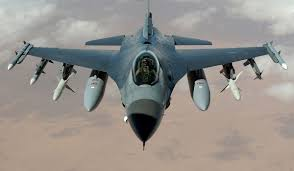

In [18]:
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import preprocess_input, decode_predictions 
# Preprocess input: scale input to the range of the trained model 
# Decode predictions: convert the prediction to human-readable labels
import numpy as np

img = image.load_img("img.jpg", target_size=(224, 224))
img_array = image.img_to_array(img)
img_batch = np.expand_dims(img_array, axis=0)
img_preprocessed = preprocess_input(img_batch)

model = ResNet50(weights='imagenet')

prediction = model.predict(img_preprocessed)

label = decode_predictions(prediction, top=3)

label



1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
35363/35363 ━━━━━━━━━━━━━━━━━━━━ 0s 1us/step


[[('n04552348', 'warplane', 0.96160185),
  ('n03773504', 'missile', 0.014286742),
  ('n04008634', 'projectile', 0.005633849)]]